# Samples a scene and parses it with both MIPMAP and IP parsing, along with plotting utilities.

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *

# DEPENDENCY
DEPENDENCY = 0
if DEPENDENCY:
    from spatial_scene_grammars_examples.singles_pairs.grammar_dependency import *
else:
    from spatial_scene_grammars_examples.singles_pairs.grammar_constituency import *
    
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *

import meshcat
import meshcat.geometry as meshcat_geom

In [3]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
    
vis.delete()

def reset_bg():
    vis['/Background'].set_property("top_color", [0.2, 0.2, 0.2])
    vis['/Background'].set_property("bottom_color", [.32, .32, .35])

base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/
Meshcat url:  http://127.0.0.1:7000/static/


In [4]:
# Draw a random sample (or load one) from the grammar and visualize it.
grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)

pyro.set_rng_seed(63)

REGENERATE = True
EXAMPLE_FILE = "single_scene.pickle"
if REGENERATE or not os.path.exists(EXAMPLE_FILE):
    with open(EXAMPLE_FILE, "wb") as f:
        tree = grammar.sample_tree(detach=True)
        observed_nodes = tree.get_observed_nodes()
        pickle.dump((tree, observed_nodes), f)

with open(EXAMPLE_FILE, "rb") as f:
    tree, observed_nodes = pickle.load(f)

print("Sampled scene with %d objects and %d pairs." % 
      (len(tree.find_nodes_by_type(Object)),
       len(tree.find_nodes_by_type(Pair))))
print("Sampled tree has score %f" % tree.score().item())
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url)
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, alpha=0.5, node_sphere_size=0.05, with_triad=False)
reset_bg()

Sampled scene with 4 objects and 1 pairs.


[2021-12-16 16:43:17.114] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Sampled tree has score -13.710506


Super tree has 15 nodes


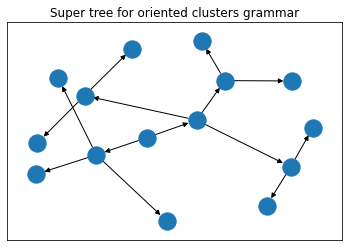

In [5]:
# Draw supertree for this grammar
super_tree = grammar.make_super_tree(max_recursion_depth=10)
nx.draw_networkx(super_tree, with_labels=False)
plt.title("Super tree for oriented clusters grammar")
print("Super tree has %d nodes" % len(list(super_tree.nodes)))

# Greedy proposal-based parsing

In [6]:
vis["greedy_scene_tree"].delete()
# Using seed 42 for thesis
pyro.set_rng_seed(42)
# Build up a big set of candidate intermediate nodes with both
# top-down and bottom-up generation.
proposed_poses_by_type = generate_candidate_node_pose_sets(
    grammar, observed_nodes, max_recursion_depth=10, verbose=True
)
parse_trees = infer_mle_tree_with_mip_from_proposals(
    grammar, observed_nodes, proposed_poses_by_type, verbose=True, N_solutions=10
)
for k, parse_tree in enumerate(parse_trees):
    score = parse_tree.score()
    print("SOL #%d: SCORE %f" % (k, score))
    draw_scene_tree_structure_meshcat(parse_tree, zmq_url=vis.window.zmq_url, prefix="greedy_scene_tree/%d_%f" % (k, score), linewidth=20, with_triad=False, node_sphere_size=0.05, alpha=0.5)

# Do NLP refinement of top trees
vis["topNrefined"].delete()
refined_trees = []
for k, mip_optimized_tree in enumerate(parse_trees):
    refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_tree, verbose=False)
    refined_trees.append(refinement_results.refined_tree)
    for node1, node2 in zip(mip_optimized_tree.nodes, refined_trees[-1].nodes):
        if isinstance(node1, Pair):
            print(node1.rotation, node2.rotation)
    draw_scene_tree_structure_meshcat(refined_trees[-1], zmq_url=vis.window.zmq_url, prefix="greedy_scene_tree/topNrefined/%d_%f" % (k, refined_trees[-1].score().item()), node_sphere_size=0.05, with_triad=False, alpha=0.5, linewidth=20)
    print(refined_trees[-1].score())

5 top-down candidates.
6 bottom-up candidates.
Post final pruning:  9
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Dec 16 16:43:18 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 414 rows, 332 columns and 1440 nonzeros
Model fingerprint: 0x900fcac1
Variable types: 0 continuous, 332 integer (332 binary)
Coefficient statistics:
  Matrix range     [8e-03, 1e+00]
  Objective range  [4e-01, 7e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 1e+00]
Presolve removed 219 rows and 107 columns
Presolve time: 0.02s
Presolved: 195 rows, 225 columns, 807 nonzeros
Variable types: 0 continuous, 225 integer (225 binary)
Found heuristic solution: objective 373.2708100

Root relaxation: objective -1.791421e+01, 47 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -17.91421  

# MIP Parsing

In [6]:
# Get single-shot parse of scene
inference_results = infer_mle_tree_with_mip(
    grammar, observed_nodes, verbose=True, max_scene_extent_in_any_dir=10., N_solutions=10
)

Starting setup.
Activation vars allocated.


Continuous variables and SO(3) constraints allocated for all equivalence sets.


Setup time:  0.6932568550109863
Num vars:  4894
Num constraints:  14063
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Wed Dec 15 02:15:10 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 10021 rows, 4894 columns and 72752 nonzeros
Model fingerprint: 0xc4d930f6
Model has 36 quadratic objective terms
Variable types: 4680 continuous, 214 integer (214 binary)
Coefficient statistics:
  Matrix range     [9e-04, 2e+01]
  Objective range  [1e-18, 1e+02]
  QObjective range [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+01]
  RHS range        [2e-01, 2e+01]
Presolve removed 3828 rows and 154 columns
Presolve time: 0.10s
Presolved: 6193 rows, 4740 columns, 53876 nonzeros
Presolved model has 36 quadratic objective terms
Variable types: 4542 continuous, 198 integer (198 binary)

Root relaxation: objective -3.034251e+02, 15844 iterations, 1.23 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Une

In [7]:
mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
draw_scene_tree_structure_meshcat(mip_optimized_trees[0], zmq_url=vis.window.zmq_url, prefix="mip_scene_tree", linewidth=20, with_triad=False, node_sphere_size=0.05, alpha=0.5, )

for tree in mip_optimized_trees:
    print(tree.score())
for node in mip_optimized_trees[0]:
    err = torch.matmul(node.rotation.transpose(0, 1), node.rotation) - torch.eye(3)
    print("Avg elementwise deviation from R^T R = I: ", err.abs().mean())

tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
tensor([-458.6527])
Avg elementwise deviation from R^T R = I:  tensor(6.4763e-17)
Avg elementwise deviation from R^T R = I:  tensor(6.4763e-17)
Avg elementwise deviation from R^T R = I:  tensor(6.4763e-17)
Avg elementwise deviation from R^T R = I:  tensor(1.4186e-16)
Avg elementwise deviation from R^T R = I:  tensor(1.9737e-16)
Avg elementwise deviation from R^T R = I:  tensor(0.0511)
Avg elementwise deviation from R^T R = I:  tensor(2.8146e-16)
Avg elementwise deviation from R^T R = I:  tensor(3.5157e-16)


In [8]:
# Do NLP refinement of top trees
vis["topNrefined"].delete()
refined_trees = []
for k, mip_optimized_tree in enumerate(mip_optimized_trees):
    refinement_results = optimize_scene_tree_with_nlp(grammar, mip_optimized_tree, verbose=False)
    refined_trees.append(refinement_results.refined_tree)
    draw_scene_tree_structure_meshcat(refined_trees[-1], zmq_url=vis.window.zmq_url, prefix="topNrefined/%d_%f" % (k, refined_trees[-1].score().item()), node_sphere_size=0.05, with_triad=False, alpha=0.5, linewidth=100)
    print(refined_trees[-1].score())
draw_scene_tree_structure_meshcat(refined_trees[0], zmq_url=vis.window.zmq_url, prefix="refined_scene_tree", node_sphere_size=0.05, with_triad=False, alpha=0.5, linewidth=50)

reset_bg()

tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
tensor([-12.7620])
